In [1]:
# Imports
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim


from brut_model import BaseModel
from dataset_builders import ScaleCellDataset


import random

# For reproducibility
random_seed = 1869
random.seed(random_seed)

In [2]:

def print_training_history(history, ck_time, title='loss and accuracy evolution'):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle(title)

    x = [i * ck_time for i in range(len(history['validation_loss']))]
    ax1.plot(x, history['train_loss'], label='training_loss', alpha=0.5, c='g')
    ax1.plot(x, history['validation_loss'], label='validation_loss', alpha=0.5, c='r')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend()

#     ax2.plot(x, history['train_accuracy'], label='training_accuracy', alpha=0.5, c='g')
#     ax2.plot(x, history['validation_accuracy'], label='validation_accuracy', alpha=0.5, c='r')
#     ax2.set_ylabel('accuracy')
#     ax2.set_xlabel('epoch')
#     ax2.legend()

    return fig


In [3]:
Training_hyper_parameters={
    
    'batch_size':10,
    'validation_split':0.3,
    
    'learning_rate':0.0001,
    'momentum':0.9,
    
    'nr_epochs': 30000, #8001,
    
    'checking_epochs': 10 # Save the model performances once at 10 epochs
}

Model_hyper_parameters={
    'inp_shape':8,
    'output_shape':4
}



In [4]:
# Artificial data 
nr_elements = 10000
xa = []
xb = []
ta = []
for i in range(nr_elements):
    ax= [[random.uniform(-1, 20.7),random.uniform(-1, 20.7)],[random.uniform(-1, 20.7),random.uniform(-1, 20.7)]]
    
    #at = [[random.randint(1, 20),random.randint(1, 10)],[random.randint(1, 10),random.randint(1, 20)]]
    at = [[random.randint(1, 20),0],[0,random.randint(1, 20)]]
    bt = [[random.randint(1, 20),0],[0,random.randint(1, 20)]]
    
    bx = np.dot(np.linalg.inv(bt),np.dot(at,ax))
    
    xa.append(ax)
    xb.append(bx)
    ta.append(at)

In [5]:
xa[0]

[[15.869020672853061, 11.922455517212358],
 [13.1917101660962, 12.156955779850394]]

In [6]:


dataset = ScaleCellDataset(xa,xb,ta)

# Split the data 

batch_size = Training_hyper_parameters['batch_size']
validation_split = Training_hyper_parameters['validation_split']
shuffle_dataset = True



# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

## Creating data loaders for trianing and vlaidation:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=len(val_indices),
                                                sampler=valid_sampler)

all_train =torch.utils.data.DataLoader(dataset, batch_size=len(train_indices), sampler=train_sampler)
##  
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([10, 8])
Labels batch shape: torch.Size([10, 4])


## Model

In [7]:
# Prepare a model 

model = BaseModel(Model_hyper_parameters) # The model that we wish to train.

print('The model:')
print(model)

print('\n\nModel params:')
for param in model.parameters():
    print(param)

The model:
BaseModel(
  (linear1): Linear(in_features=8, out_features=16, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=16, bias=True)
  (linear5): Linear(in_features=16, out_features=4, bias=True)
)


Model params:
Parameter containing:
tensor([[-0.1083,  0.1032,  0.0850,  0.0516,  0.0991, -0.0094,  0.1844,  0.0057],
        [-0.1093, -0.1680,  0.1280,  0.1414, -0.3247,  0.0773, -0.0391,  0.2287],
        [ 0.2473,  0.2065, -0.1322, -0.0566,  0.0549, -0.1923,  0.3427, -0.0707],
        [ 0.3081,  0.1721,  0.0899, -0.3137, -0.1820,  0.1181,  0.0109,  0.3457],
        [-0.3388, -0.1676,  0.3404,  0.1382,  0.1165, -0.3027,  0.1658, -0.0191],
        [-0.3516, -0.0639,  0.3389, -0.1003,  0.2385, -0.2907,  0.0646,  0.3473],
        [ 0.1248,  0.2825,  0.1357, -0.1180, -0.1327, -0.1694, -0.0421, -0.0409],
        [ 0.2409, -0.03

## Training 

In [8]:
#Loss function
def human_loss(output, target):
#     print("o",output)
#     print("t",target)
    a = torch.square(output-target)
    cost = torch.sum(a)
    return cost

criterion = human_loss # nn.CrossEntropyLoss()

# Optimizer
learning_rate = Training_hyper_parameters['learning_rate']
momentum = Training_hyper_parameters['momentum']                             
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [9]:
# actual training 

## Work in progress ##

nr_epochs = Training_hyper_parameters['nr_epochs']
ck_time = Training_hyper_parameters['checking_epochs']

history = {'train_loss':[],'validation_loss':[], 'train_accuracy':[] , 'validation_accuracy':[]}

for epoch in range(nr_epochs):  
    model.train(True)
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss/len(train_loader)
        loss.backward()
        optimizer.step()
    
    if epoch%100 == 0:
        print('Epoch {}| loss:{}'.format(epoch + 1,train_loss ))
    
    if epoch % ck_time == 0:
        
        #training
        for i, data in enumerate(all_train):
            inputs_t, labels_t = data
            outputs_t = model(inputs_t)
            
            tl = criterion(outputs_t, labels_t).detach().numpy()
            
        
        history['train_loss'].append(tl)
       
        #validation
        for i, data in enumerate(validation_loader):
            inputs_v, labels_v = data
            outputs_v = model(inputs_v)
            
        vl = criterion(outputs_v, labels_v).detach().numpy()
        
        history['validation_loss'].append(vl)
        
        
        
print('-Training finished-')

Epoch 1| loss:1727.31298828125
Epoch 101| loss:318.7264404296875
Epoch 201| loss:309.5958251953125
Epoch 301| loss:305.5770568847656
Epoch 401| loss:302.7877197265625
Epoch 501| loss:300.90087890625
Epoch 601| loss:300.0138854980469
Epoch 701| loss:298.1723937988281
Epoch 801| loss:296.77154541015625
Epoch 901| loss:296.246826171875
Epoch 1001| loss:295.3368225097656
Epoch 1101| loss:294.7000427246094
Epoch 1201| loss:294.6486511230469
Epoch 1301| loss:292.91741943359375
Epoch 1401| loss:292.21197509765625
Epoch 1501| loss:291.03509521484375
Epoch 1601| loss:290.5935363769531
Epoch 1701| loss:290.3180847167969
Epoch 1801| loss:289.4108581542969
Epoch 1901| loss:288.76031494140625
Epoch 2001| loss:287.8811340332031
Epoch 2101| loss:287.0547180175781
Epoch 2201| loss:286.96575927734375
Epoch 2301| loss:285.91839599609375
Epoch 2401| loss:284.807373046875
Epoch 2501| loss:284.8484191894531
Epoch 2601| loss:283.0626525878906
Epoch 2701| loss:282.7388000488281
Epoch 2801| loss:282.321960449

KeyboardInterrupt: 

In [ ]:
ck_time

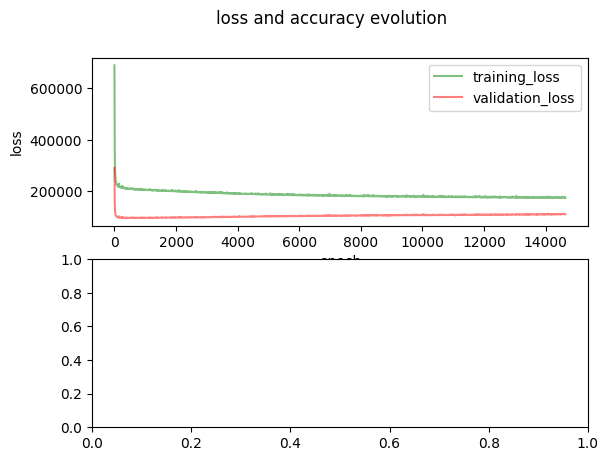

In [10]:
# Training evolution:

fig_trainig_evolution = print_training_history(history, ck_time)

# print("\nModel performance:")
# for k in history:
#     print("{}".format(k),history[k][len(history[k])-1])
# print("__________________")

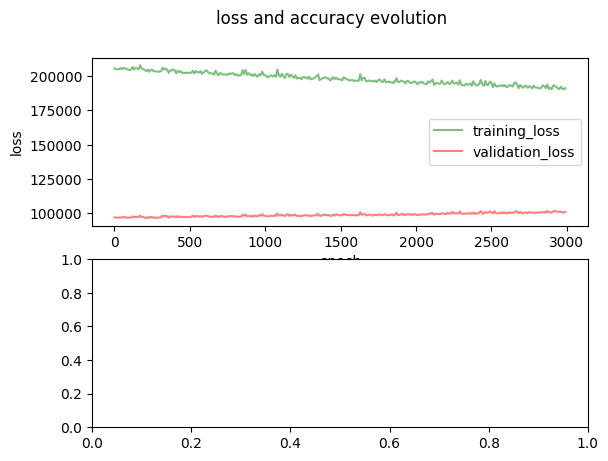

In [11]:


def print_training_history(history, ck_time, title='loss and accuracy evolution', cut=400):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle(title)

    x = [i * ck_time for i in range(len(history['validation_loss'][100:cut]))]
    ax1.plot(x, history['train_loss'][100:cut], label='training_loss', alpha=0.5, c='g')
    ax1.plot(x, history['validation_loss'][100:cut], label='validation_loss', alpha=0.5, c='r')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend()
    
fig_trainig_evolution = print_training_history(history, ck_time)

In [12]:
a = np.array([[0,1],[1,0]])
b = np.array([[0,5],[5,0]])
xa_v= torch.tensor([0.0,1.0,1.0,0.0,0.0,5.0,5.0,0.0])
outputs_v = model(xa_v)
print(torch.reshape(outputs_v,(2,2)))

tensor([[19.4618,  0.0000],
        [ 0.0000, 13.3927]], grad_fn=<ReshapeAliasBackward0>)
